In [90]:
import os
import sys

import xarray as xr
import numpy as np
import zarr

import pandas as pd

import s3fs
import gcsfs
import boto3

import math

from shapely import geometry

import matplotlib
import matplotlib.pyplot as plt

import itertools
from functools import partial

import seaborn as sns

from dask.distributed import Client

import cartopy.crs as ccrs
import cartopy.feature as cf

import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures


sys.path.append('../analysis/physiology/')
import tpc

GCP_PROJECT_ID = '170771369993'
OISST_GCP = 'oisst/oisst.zarr'

%matplotlib inline

In [2]:
dask_client = Client()
dask_client

Client Scheduler: tcp://127.0.0.1:38675 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.45 GB


# Use $T_\mathrm{opt}$ model to extrapolate performance. 

In [this other notebook](./physiology/geographic_TPC_patterns.ipynb) I fit curves to the phytoplankton perfomance parameters, and the following relationship seems promising: 

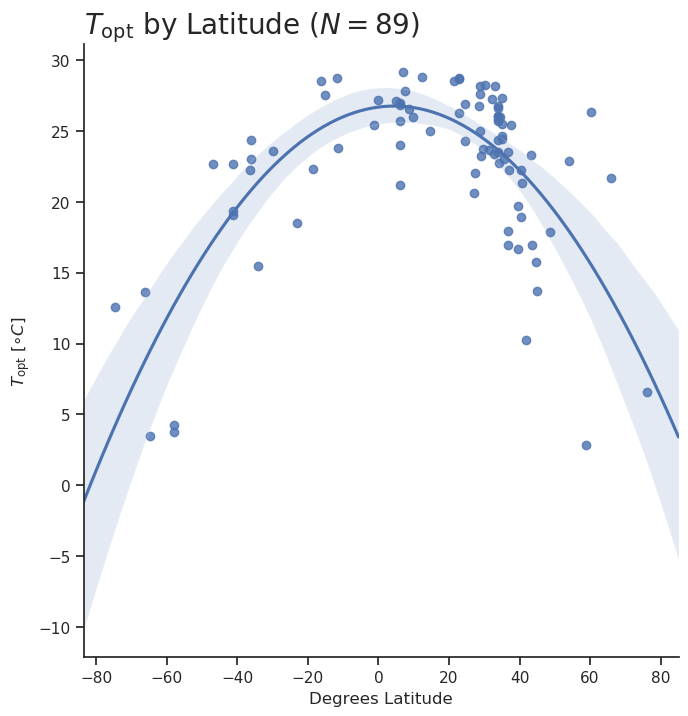

We'll use this relationship to compute difference from $T_\mathrm{opt}$ during MHW events + other times. 

## Load Model & Data

In [3]:
# Load Model
# topt_poly = sm.load("physiology/latitude_polynomial_topt.model")
topt_poly = sm.load("physiology/latitude_polynomial_topt_relaxed.model")

In [4]:
# Load SST
fs = gcsfs.GCSFileSystem(project=GCP_PROJECT_ID, token="../gc-pangeo.json")
oisst = xr.open_zarr(fs.get_mapper(OISST_GCP))
oisst = oisst.assign_coords(lon=(((oisst.lon + 180) % 360) - 180)).sortby('lon')
# Slice to PNW
PNW_LAT = slice(30, 60)
PNW_LON = slice(-155.9, -120.9)
oisst_pnw = oisst.sel(lat = PNW_LAT, lon = PNW_LON).compute()
# Load MHWs
awsfs = s3fs.S3FileSystem()
mhw_mapper = s3fs.S3Map("s3://mhw-stress/new_with_climatology", s3=awsfs)
mhws = xr.open_zarr(mhw_mapper, consolidated=True)
mhws = mhws.chunk({
    'lat': 100, 
    'lon' : 100, 
    'time': 500
})

In [6]:
## Set up Plotting
CENTRAL_LONGITUDE = ((mhws.lon.max() + mhws.lon.min()) / 2).values
CENTRAL_LATITUDE = ((mhws.lat.max() + mhws.lat.min()) / 2).values
PLOT_MAP_PROJECTION = ccrs.Stereographic(central_longitude=CENTRAL_LONGITUDE)
extent = [
    oisst_pnw.lon.min().values,
    oisst_pnw.lon.max().values,
    oisst_pnw.lat.min().values,
    oisst_pnw.lat.max().values

]

## Define Thermal Performance Metric

Here, we'll compute the thermal performance metric $M$ as follows, where $f$ is the polynomial function above giving modeled $T_\mathrm{opt}$ by latitude: $$M(T, \mathrm{lat}) = T - f(\mathrm{lat})$$
This we can refer to as "departure from $T_\mathrm{opt}$". 

In [7]:
topt = xr.full_like(oisst_pnw.isel(time=0), fill_value=0.).drop('time').rename_vars({'sst' : "Topt"})
topt.attrs = {}

### Compute Topt latitudinally

In [8]:
X = PolynomialFeatures(2).fit_transform(abs(topt.lat.values.reshape(-1, 1)))
_topt = topt_poly.predict(X)
for _data, lat in zip(_topt, topt.lat.values):
    topt['Topt'].loc[
        dict(lat = lat)
    ] = _data

## Compute Departure from $T_\mathrm{opt}$

We compute this at actual SST and climatology. 

**Perhaps it's best we switch this**

In [9]:
# departure = topt.Topt - oisst_pnw.sst
# departure_clim = topt.Topt - mhws.clim_seas 
departure =  oisst_pnw.sst - topt.Topt
departure_clim = mhws.clim_seas - topt.Topt


## Plots

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


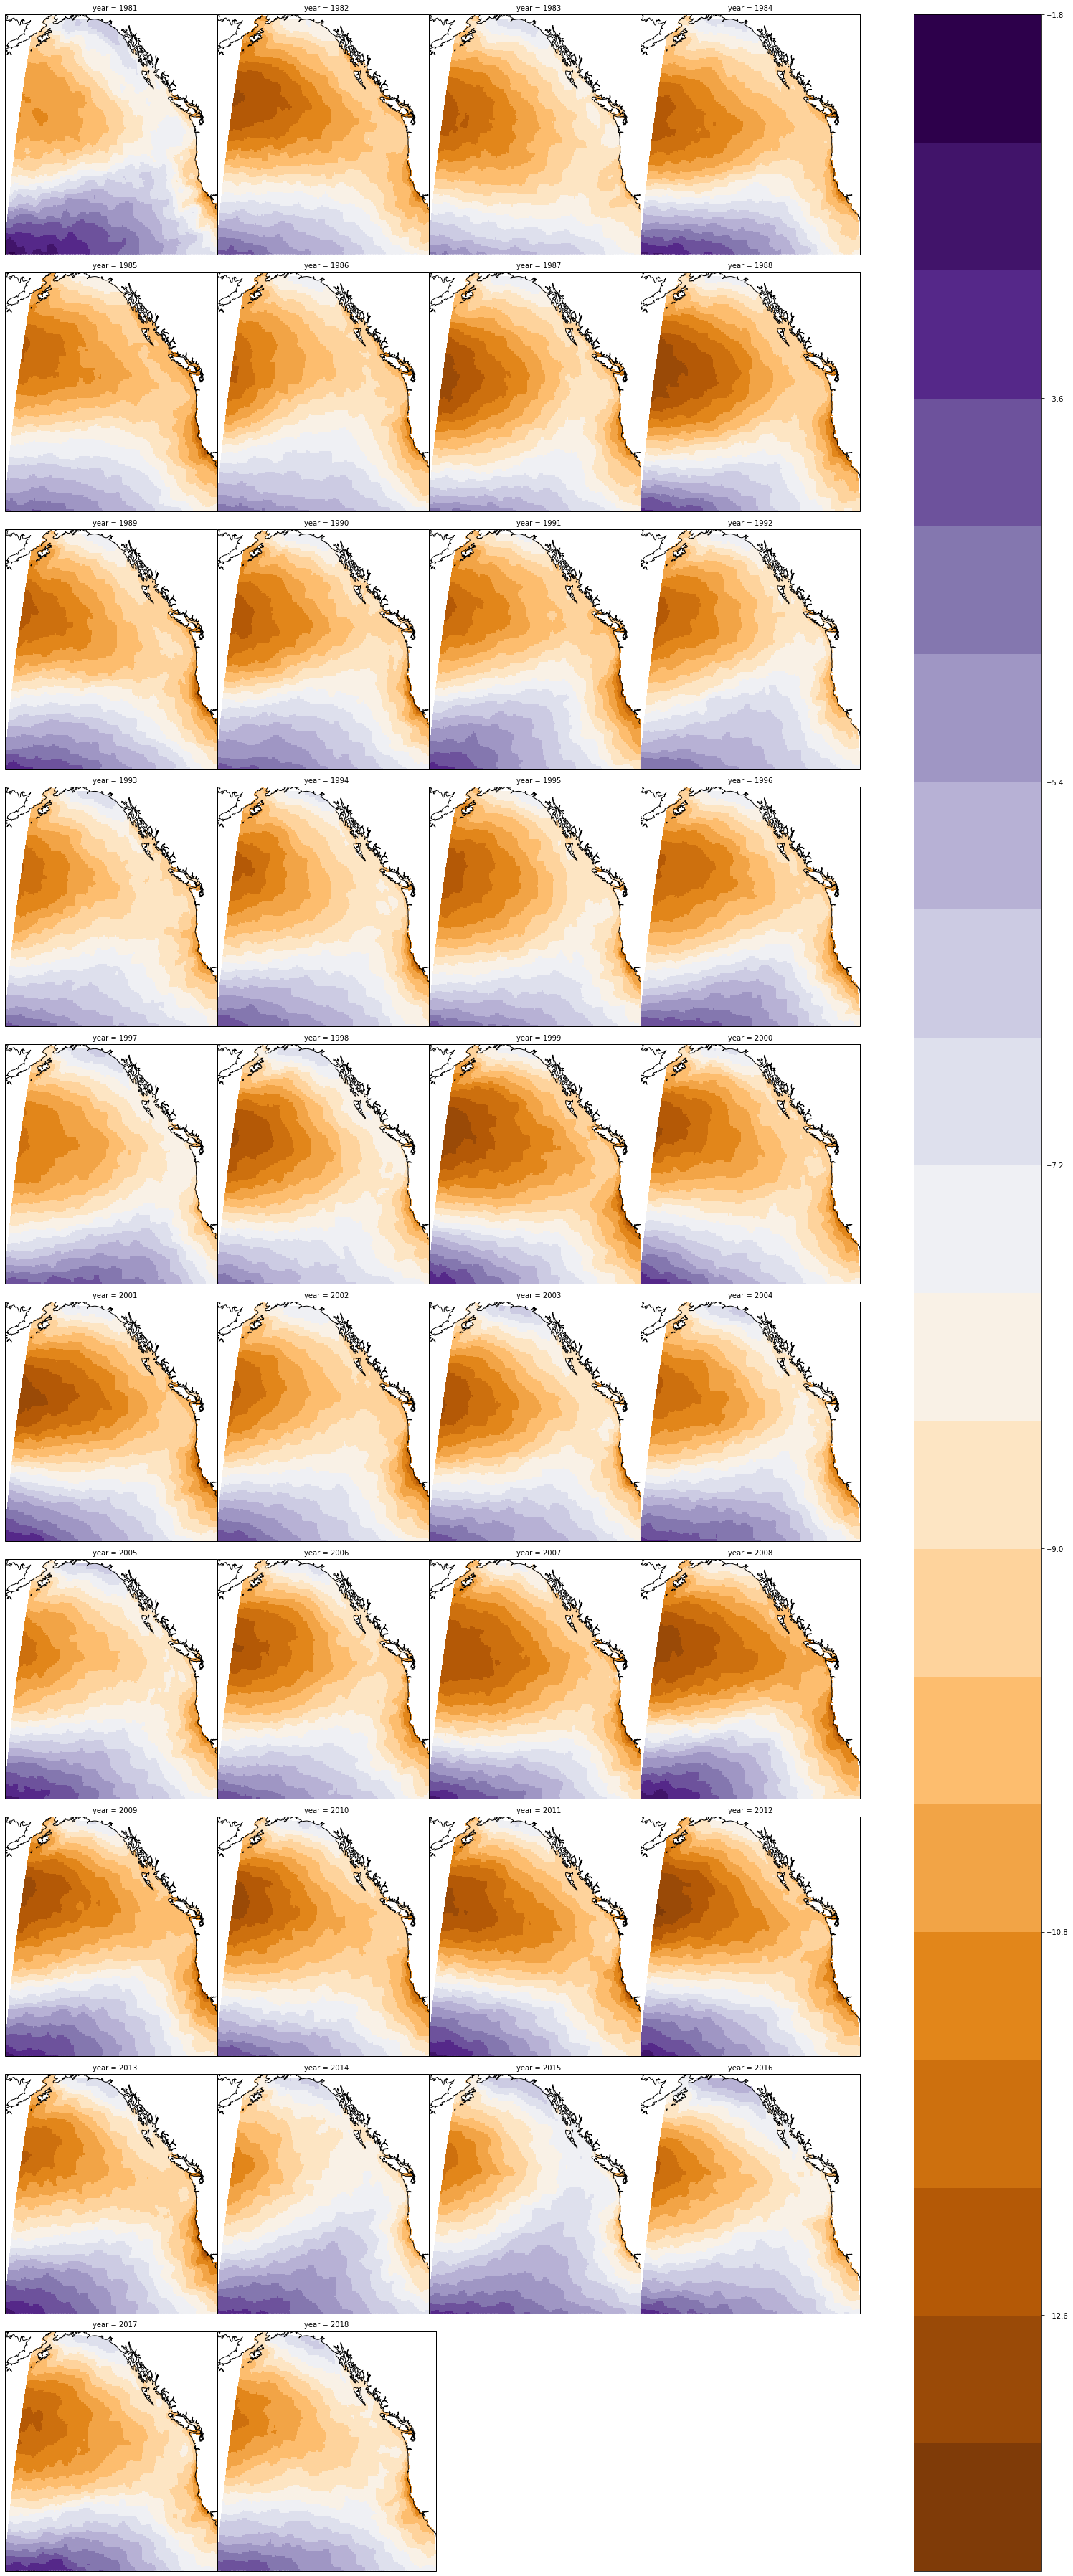

In [35]:
fg = departure \
    .groupby('time.year') \
    .mean(dim='time') \
    .plot.pcolormesh( 
        size=5, 
        levels=20, 
        col='year', col_wrap=4,
        cmap='PuOr', transform=ccrs.PlateCarree(), 
        subplot_kws={'projection': PLOT_MAP_PROJECTION}, 
    )
list(map(lambda x: x.set_extent(extent), fg.axes.ravel()))
list(map(lambda x: x.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k'), fg.axes.ravel()));

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'cbar_kws'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/xarray/plot/facetgrid.py:371: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


Text(0.5, 0.98, '2015')

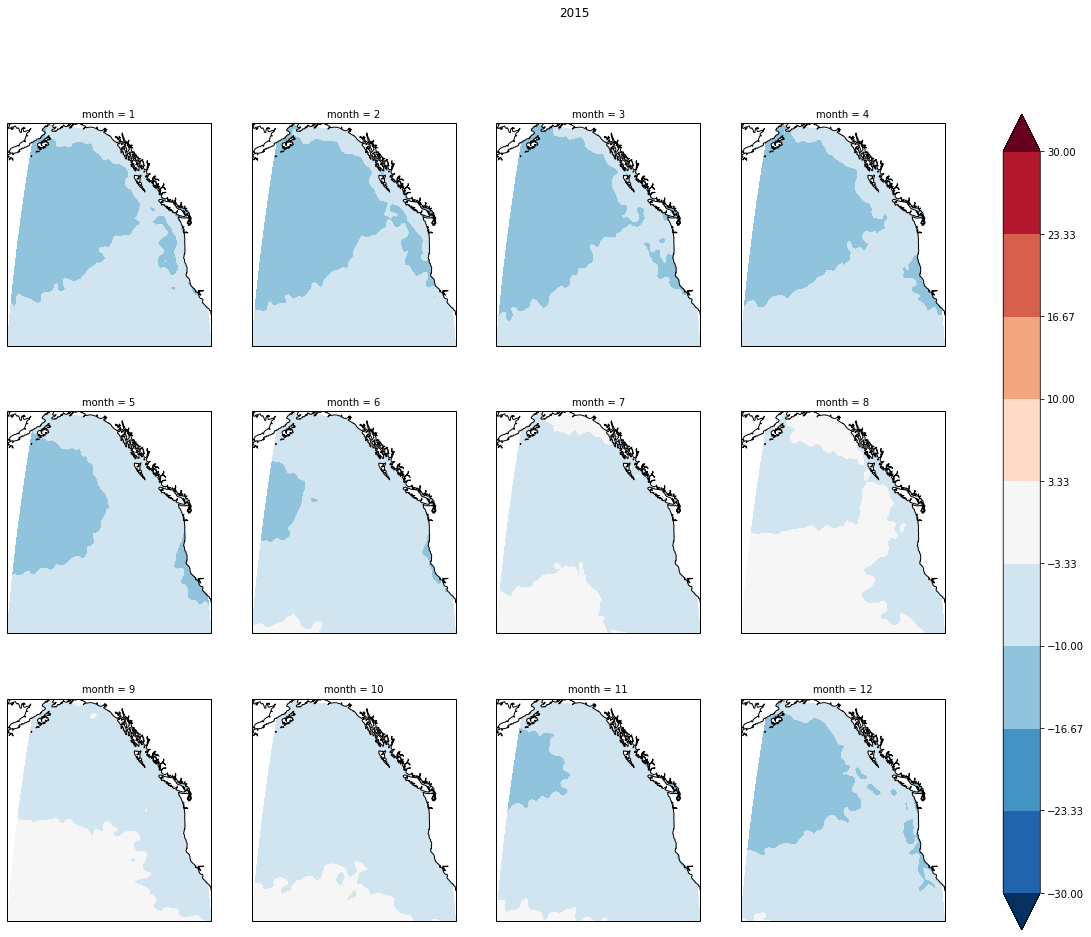

In [36]:
fg = departure.sel(time='2015').groupby('time.month').mean(dim='time').plot.contourf(
    col='month', col_wrap=4, size=5, vmax= 30, vmin=-30, levels=10, extend='both',
    transform=ccrs.PlateCarree(), cmap='RdBu_r',
    subplot_kws={'projection': PLOT_MAP_PROJECTION},
    cbar_kws={'label': "TPC difference from TPC(climatology)"}
)
list(map(lambda x: x.set_extent(extent), fg.axes.ravel()))
list(map(lambda x: x.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k'), fg.axes.ravel()))
# fg.cbar.set_label("TPC - TPC(climatology)")

fg.fig.suptitle("2015")

## Regional Trends over TIme

In [10]:
DURATION_THRESHOLD = 45
mhw_only_filter = (mhws.mhw !=0) & (mhws.duration >= DURATION_THRESHOLD)
non_mhw_filter = ~(mhws.mhw.notnull())

In [11]:
study_region = {
    'lat' : slice(29, 47),
    'lon' : slice(-151, -131)
}
time_period = ["2010", "2019"]

In [12]:
regional_departure = departure.sel(**study_region)
regional_departure_clim = departure_clim.sel(**study_region)

In [13]:
mhw_only_sst = oisst_pnw.sel(**study_region).where(mhw_only_filter, drop=True)
non_mhw_sst = oisst_pnw.sel(**study_region).where(~mhw_only_filter)

In [18]:
regional_mhws = mhws.sel(**study_region).where(mhw_only_filter, drop=True)

In [23]:
regional_mhws_start = np.unique(regional_mhws.index_start.values.flatten())

In [24]:
regional_mhws_end = np.unique(regional_mhws.index_end.values.flatten())

In [28]:
regional_mhws_.shape[0]

28648099

In [26]:
np.array([
    regional_mhws_start[:regional_mhws_end.shape[0]],
    regional_mhws_end
])

array([array([858., 860., 876., ...,  nan,  nan,  nan]),
       array([906., 934., 943., ...,  nan,  nan,  nan])], dtype=object)

(733773.0, 737060.0)

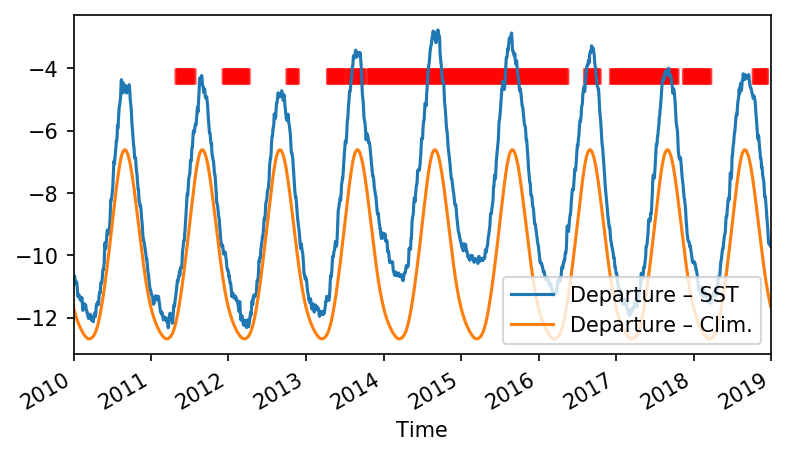

In [56]:
plt.figure(figsize=(6,3), dpi=150)
departure.mean(['lat', 'lon']).plot(label='Departure – SST')
departure_clim.mean(['lat', 'lon']).plot(label='Departure – Clim.')

plt.legend(loc='lower right')
plt.vlines(mhw_only_sst.time.values, ymin=-4.5, ymax=-4, color='red', alpha=0.2, )
plt.xlim(time_period)

In [51]:
detriment_ratio =(regional_departure / regional_departure_clim).persist()

(733773.0, 737060.0)

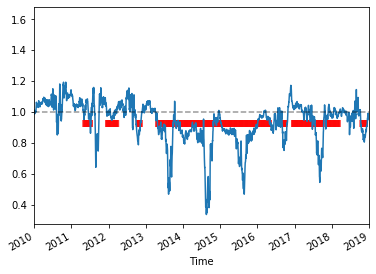

In [52]:
detriment_ratio.mean(['lat', 'lon']).plot()
plt.vlines(mhw_only_sst.time.values, ymin=0.9, ymax=0.95, color='red', alpha=0.2, )

plt.axhline(1, color='k', linestyle='--', alpha=0.4)
plt.xlim(time_period)

In [14]:
detriment_difference =(regional_departure - regional_departure_clim).persist()

(733773.0, 737060.0)

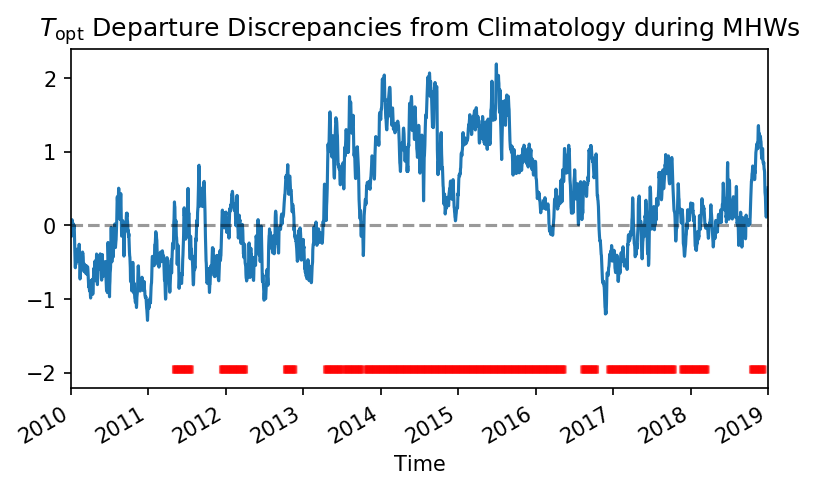

In [54]:
plt.figure(figsize=(6,3), dpi=150)
detriment_difference.mean(['lat', 'lon']).sel(time=slice('2010', '2019')).plot()
plt.vlines(mhw_only_sst.time.values, ymin=-2, ymax=-1.9, color='red', alpha=0.2, )

plt.axhline(0, color='k', linestyle='--', alpha=0.4)
plt.title("$T_\mathrm{opt}$ Departure Discrepancies from Climatology during MHWs")
plt.xlim(['2010', '2019'])

## MHW vs Non MHW Times

In [15]:
diff_mhw = detriment_difference.where(mhw_only_filter, drop=True)
diff_nomhw = detriment_difference.where(~mhw_only_filter, drop=True)

In [19]:
diff_mhw = xr.merge([diff_mhw.rename("diff_mhw"), regional_mhws.intensity_mean], )

KilledWorker: ('zarr-6e21399271b0ef5d553787726c61ee18', <Worker 'tcp://127.0.0.1:43285', memory: 0, processing: 2>)

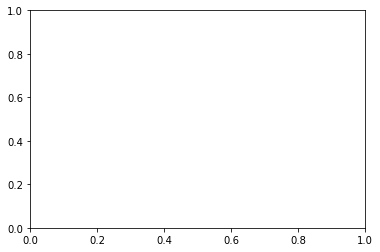

In [99]:
xr.plot.scatter(diff_mhw, x='intensity_mean', y='diff_mhw')

In [ ]:
X = diff_mhw['intensity_mean'].values.flatten()
Y = diff_mhw['diff_mhw'].values.flatten()

_lm_diff = sm.OLS(X, Y).fit()

In [ ]:
plt.scatter(X, Y)

In [61]:
X = diff_mhw['intensity_mean'].values.flatten()
Y = diff_mhw['diff_mhw'].values.flatten()

stack = np.stack([X, Y]).T


In [62]:
stack = np.stack([X, Y]).T

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


Error in callback <function flush_figures at 0x7f34c32e98c0> (for post_execute):


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker


In [64]:
stack = stack[~np.isnan(stack).any(axis=1)]

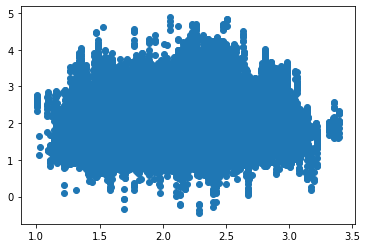

In [65]:
plt.scatter(stack[:, 0], stack[:, 1])

In [76]:
X = stack[:,0]
Y = stack[:,1]
_lm_diff = sm.OLS(X, Y).fit()

In [77]:
X_hat = np.linspace(X.min(), X.max())
Y_hat = _lm_diff.get_prediction(X)
# plt.plot(X_hat, Y_hat)
# plt.scatter(X, Y, alpha=0.1)

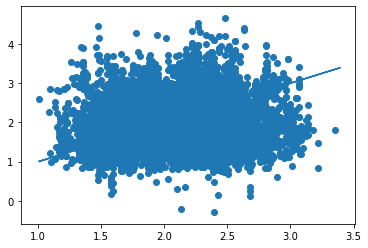

In [98]:
plt.plot(X, Y_hat.predicted_mean)
ridx = np.random.choice(np.arange(len(X)), size=math.ceil(len(X)*0.1))
subset_stack = stack[ridx]
plt.scatter(subset_stack[:,0], subset_stack[:,1])

In [56]:
df = pd.DataFrame({
    'x': X, 
 
    'y': Y
}

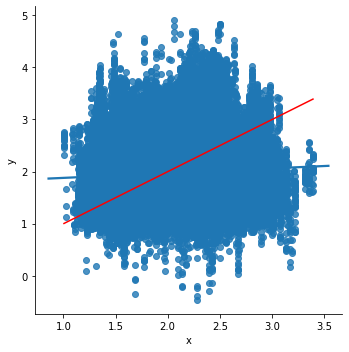

In [59]:
sns.lmplot('x', 'y', df)
plt.plot(X_hat, Y_hat, color='red')